# Set up

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
import statsmodels.api as sm
from statsmodels.api import OLS

# BlackBoxAuditing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [161]:
lc_census_merged14 = pd.read_csv('../data/2014_loan_data/pct_accepted_by_zip3_2014_ALL.csv', dtype={'zip_3':str})
all_loans_2014 = pd.read_csv('../hugo/all_loans_2014', dtype={'ZIP':str}, low_memory = False)
all_loans_2015 = pd.read_csv('../hugo/all_loans_2015', dtype={'ZIP':str}, low_memory = False)
census = pd.read_csv('../data/census_zip3.csv', dtype={'zip_3':str})
loans_bought14 = pd.read_csv('../hugo/loans_bought_2014', dtype={'ZIP':str}, header=1)
loans_bought15 = pd.read_csv('../hugo/loans_bought_2015', dtype={'ZIP':str}, header=1)

In [162]:
loans_bought14.Real_ROI = pd.to_numeric(loans_bought14.Real_ROI, errors='coerce')
loans_bought14.annualized_amnt = pd.to_numeric(loans_bought14.annualized_amnt, errors='coerce')
loans_bought14.amnt = pd.to_numeric(loans_bought14.amnt, errors='coerce')
loans_bought15.Real_ROI = pd.to_numeric(loans_bought15.Real_ROI, errors='coerce')
loans_bought15.annualized_amnt = pd.to_numeric(loans_bought15.annualized_amnt, errors='coerce')
loans_bought15.amnt = pd.to_numeric(loans_bought15.amnt, errors='coerce')

In [163]:
all_loans_2014_merged = all_loans_2014.merge(census, "left", left_on="ZIP", right_on="zip_3")
all_loans_2015_merged = all_loans_2015.merge(census, "left", left_on="ZIP", right_on="zip_3")
loans_bought14_merged = loans_bought14.merge(census, "left", left_on="ZIP", right_on="zip_3")
loans_bought15_merged = loans_bought15.merge(census, "left", left_on="ZIP", right_on="zip_3")

Random EDA.

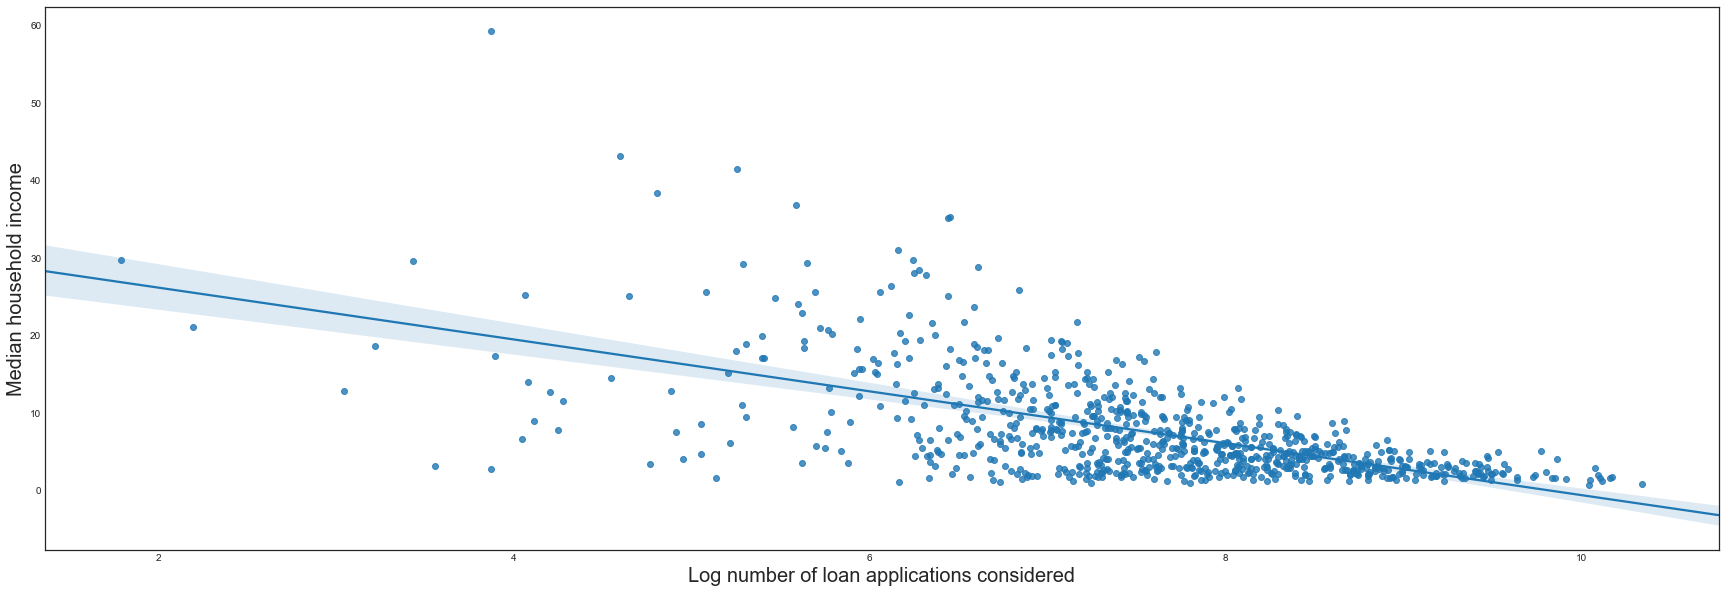

In [164]:
plt.figure(figsize=(30,10))
sns.regplot(np.log(lc_census_merged14.num_loan_apps_considered), lc_census_merged14.Median_household_inc)
plt.xlabel('Log number of loan applications considered', fontsize=20)
plt.ylabel('Median household income', fontsize=20)
plt.show()

# What variables should we care about?

[Legally protected classes](https://content.next.westlaw.com/Document/Ibb0a38daef0511e28578f7ccc38dcbee/View/FullText.html?contextData=sc.Default&transitionType=Default&firstPage=true&bhcp=1):
* Race
* Color
* Religion or creed
* National origin or ancestry
* Sex
* Age
* Physical or mental disability
* Veteran status
* Genetic information
* Citizenship

Characteristics that are protected by being an Equal Housing Lender, which Lending Club is:
* Race
* Color
* Religion
* National origin
* Sex
* Handicap
* Familial status

Other variables research suggests is correlated to socioeconomic status and other important socio-political outcomes:
* **Education**
* Unemployment
* Poverty
* Income/wealth

<hr>
Variables we have through Lending Club (individual-level fairness):
* Income (`annual_inc_joint`, `annualInc`)
* Loan description (could be used to back out loans for families, for instance) (`desc`)
    * This is something we'd need text analysis for, probably beyond our scope
* Debt-to-income ratio (`dti`)
* Number of mortgage accounts (could be used to back out loans for families) (`mortAcc`)
* Job description (`emp_title`)

Variables that we have through the Census (group-level fairness): 
* Race
* Education
* Family status
* Gender x age
* Unemployment rate
* Workforce
* Household income

<hr>

Synthesizing, it seems like these are our best options for proceeding:

| Type | Features |
| --- | --- |
| Individual-level fairness | *Income* |
| Group-level fairness | *Race, family status, education, unemployment* |

Will consider both **post-hoc** adjustments to achieve fairness (statistical/conditional parity, calibration/predictive equality) and **built-in** fairness features (adjusting the loss function to balance loss by a group of interest).

# Individual-level fairness

* just using reject data, see if people in same zip codes with different dti, risk scores, employment lengths are rejected differently
* histograms for dti and risk score and bar charts for employment

Going to need more full data set to do this, not the scaled back one we have here (i.e., all columns).

# Group-level fairness

First just look at distribution of scores among different quantiles of different demographics.

In [165]:
def plot_distr_quantiles(feature, score, title, xlabel, ax):
    tiles = np.percentile(feature.dropna(), [0,25,50,75,100])
    _0_25 = feature < tiles[1]
    _25_50 = (feature < tiles[2]) & (feature > tiles[1])
    _50_75 = (feature < tiles[3]) & (feature > tiles[2])
    _75_100 = (feature < tiles[4]) & (feature > tiles[3])

    sns.kdeplot(score[_0_25==True].dropna(), color="green", label="1st quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_25_50==True].dropna(), color="purple", label="2nd quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_50_75==True].dropna(), color="orange", label="3rd quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_75_100==True].dropna(), color="blue", label="4th quartile", alpha=0.5, ax=ax)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=15)

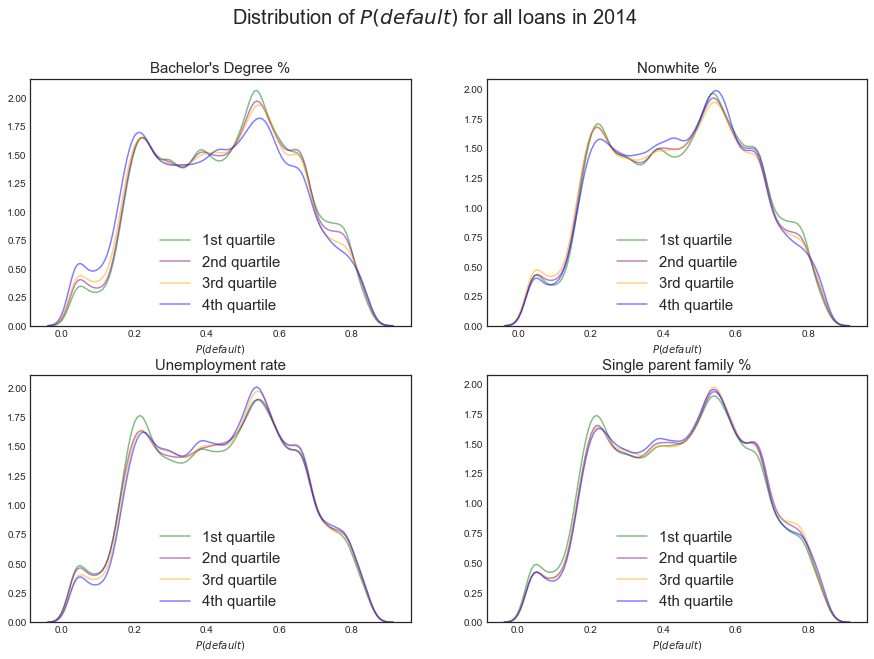

In [166]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_distr_quantiles(all_loans_2014_merged.Bachelors_Degree_pct, all_loans_2014_merged.proba, "Bachelor's Degree %", r"$P(default)$",ax[0,0])
plot_distr_quantiles(all_loans_2014_merged.nonwhite_pct, all_loans_2014_merged.proba, "Nonwhite %", r"$P(default)$",ax[0,1])
plot_distr_quantiles(all_loans_2014_merged.Unemployment_Rate_pct, all_loans_2014_merged.proba, "Unemployment rate", r"$P(default)$", ax[1,0])
plot_distr_quantiles(all_loans_2014_merged.Single_parent_families, all_loans_2014_merged.proba, "Single parent family %", r"$P(default)$", ax[1,1])
plt.suptitle(r"Distribution of $P(default)$ for all loans in 2014", fontsize=20)
plt.show()

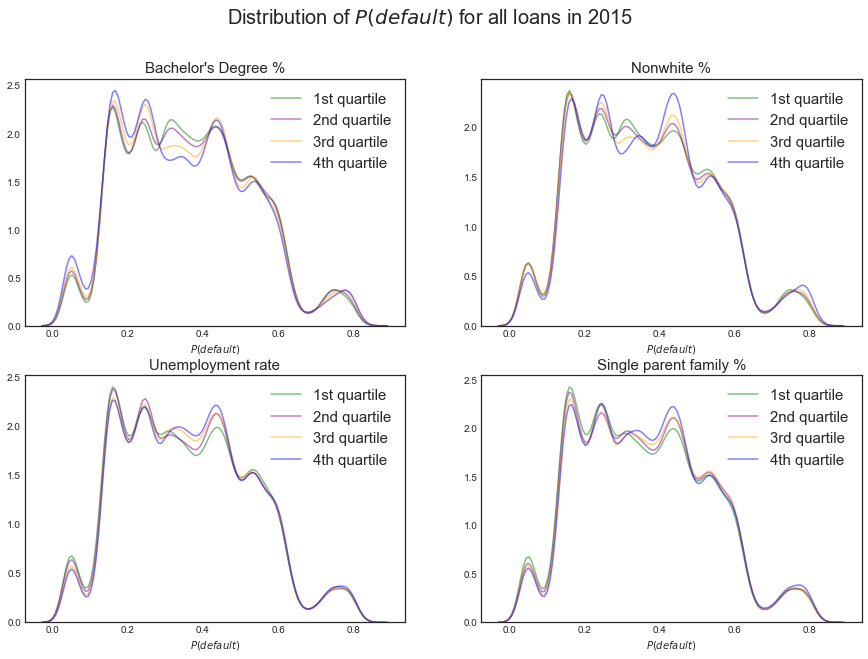

In [167]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_distr_quantiles(all_loans_2015_merged.Bachelors_Degree_pct, all_loans_2015_merged.proba, "Bachelor's Degree %", r"$P(default)$", ax[0,0])
plot_distr_quantiles(all_loans_2015_merged.nonwhite_pct, all_loans_2015_merged.proba, "Nonwhite %", r"$P(default)$", ax[0,1])
plot_distr_quantiles(all_loans_2015_merged.Unemployment_Rate_pct, all_loans_2015_merged.proba, "Unemployment rate", r"$P(default)$", ax[1,0])
plot_distr_quantiles(all_loans_2015_merged.Single_parent_families, all_loans_2015_merged.proba, "Single parent family %", r"$P(default)$", ax[1,1])
plt.suptitle(r"Distribution of $P(default)$ for all loans in 2015", fontsize=20)
plt.show()

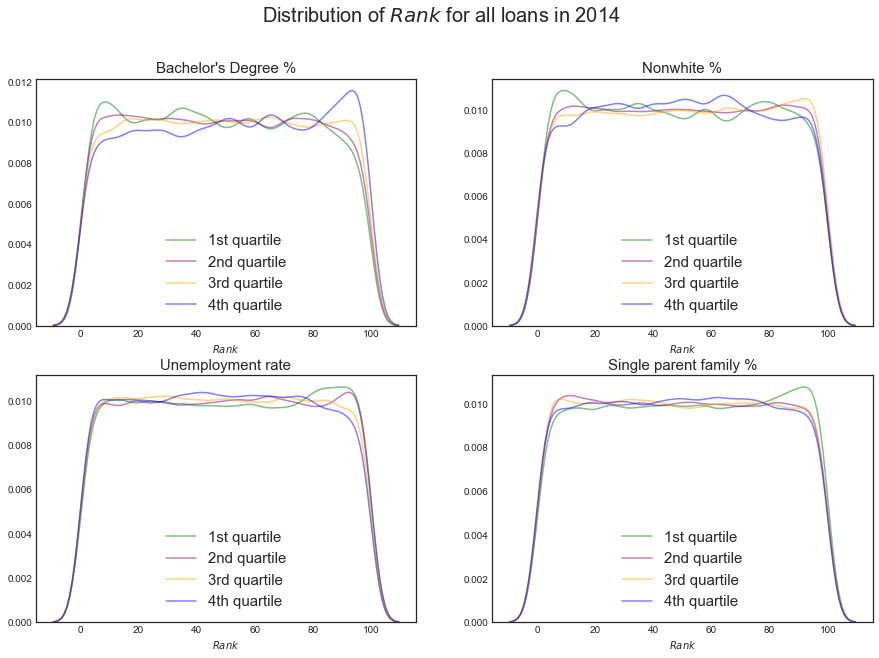

In [168]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_distr_quantiles(all_loans_2014_merged.Bachelors_Degree_pct, all_loans_2014_merged.Rank, "Bachelor's Degree %", r"$Rank$", ax[0,0])
plot_distr_quantiles(all_loans_2014_merged.nonwhite_pct, all_loans_2014_merged.Rank, "Nonwhite %", r"$Rank$", ax[0,1])
plot_distr_quantiles(all_loans_2014_merged.Unemployment_Rate_pct, all_loans_2014_merged.Rank, "Unemployment rate", r"$Rank$", ax[1,0])
plot_distr_quantiles(all_loans_2014_merged.Single_parent_families, all_loans_2014_merged.Rank, "Single parent family %", r"$Rank$", ax[1,1])
plt.suptitle(r"Distribution of $Rank$ for all loans in 2014", fontsize=20)
plt.show()

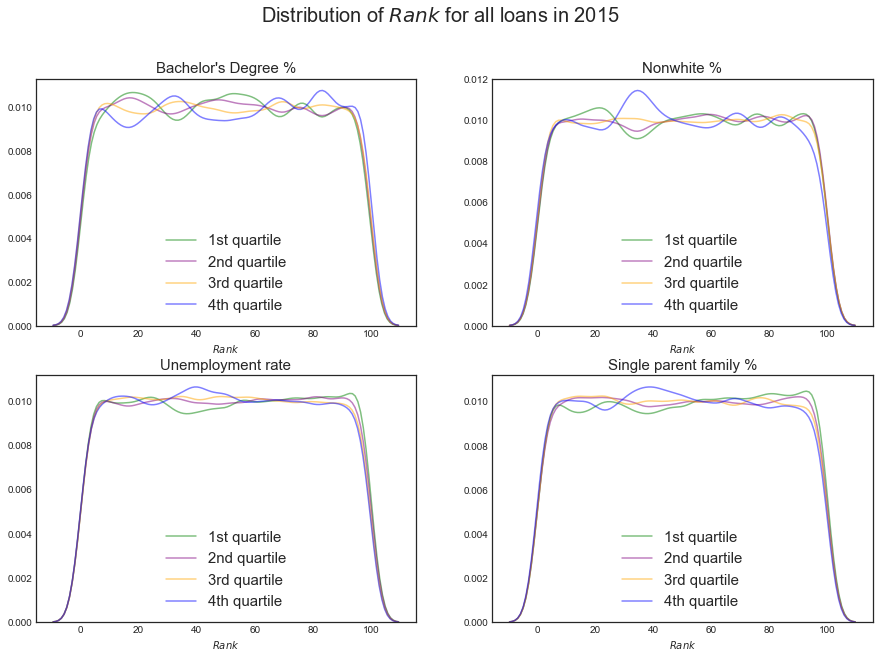

In [169]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_distr_quantiles(all_loans_2015_merged.Bachelors_Degree_pct, all_loans_2015_merged.Rank, "Bachelor's Degree %", r"$Rank$", ax[0,0])
plot_distr_quantiles(all_loans_2015_merged.nonwhite_pct, all_loans_2015_merged.Rank, "Nonwhite %", r"$Rank$", ax[0,1])
plot_distr_quantiles(all_loans_2015_merged.Unemployment_Rate_pct, all_loans_2015_merged.Rank, "Unemployment rate", r"$Rank$", ax[1,0])
plot_distr_quantiles(all_loans_2015_merged.Single_parent_families, all_loans_2015_merged.Rank, "Single parent family %", r"$Rank$", ax[1,1])
plt.suptitle(r"Distribution of $Rank$ for all loans in 2015", fontsize=20)
plt.show()

Now going to want to use selected subset and count number of loans we choose to invest in by zip code and compare that to the number of loan applications received in that zip code.

In [170]:
num_loans_invested_zip14 = loans_bought14.groupby(['ZIP'])['ZIP'].agg(['count']).reset_index()
num_loans_total_zip14 = all_loans_2014_merged.groupby(['ZIP'])['ZIP'].agg(['count']).reset_index()

In [171]:
loans14 = num_loans_invested_zip14.merge(num_loans_total_zip14, 'left', left_on='ZIP', right_on='ZIP')

In [172]:
loans14.columns = ['ZIP', 'invest', 'total_approved']

In [173]:
loans14['pct_invested'] = loans14.invest/loans14.total_approved

In [174]:
loans_approved_invested14 = loans14.merge(lc_census_merged14, 'left', left_on='ZIP', right_on='zip_3')

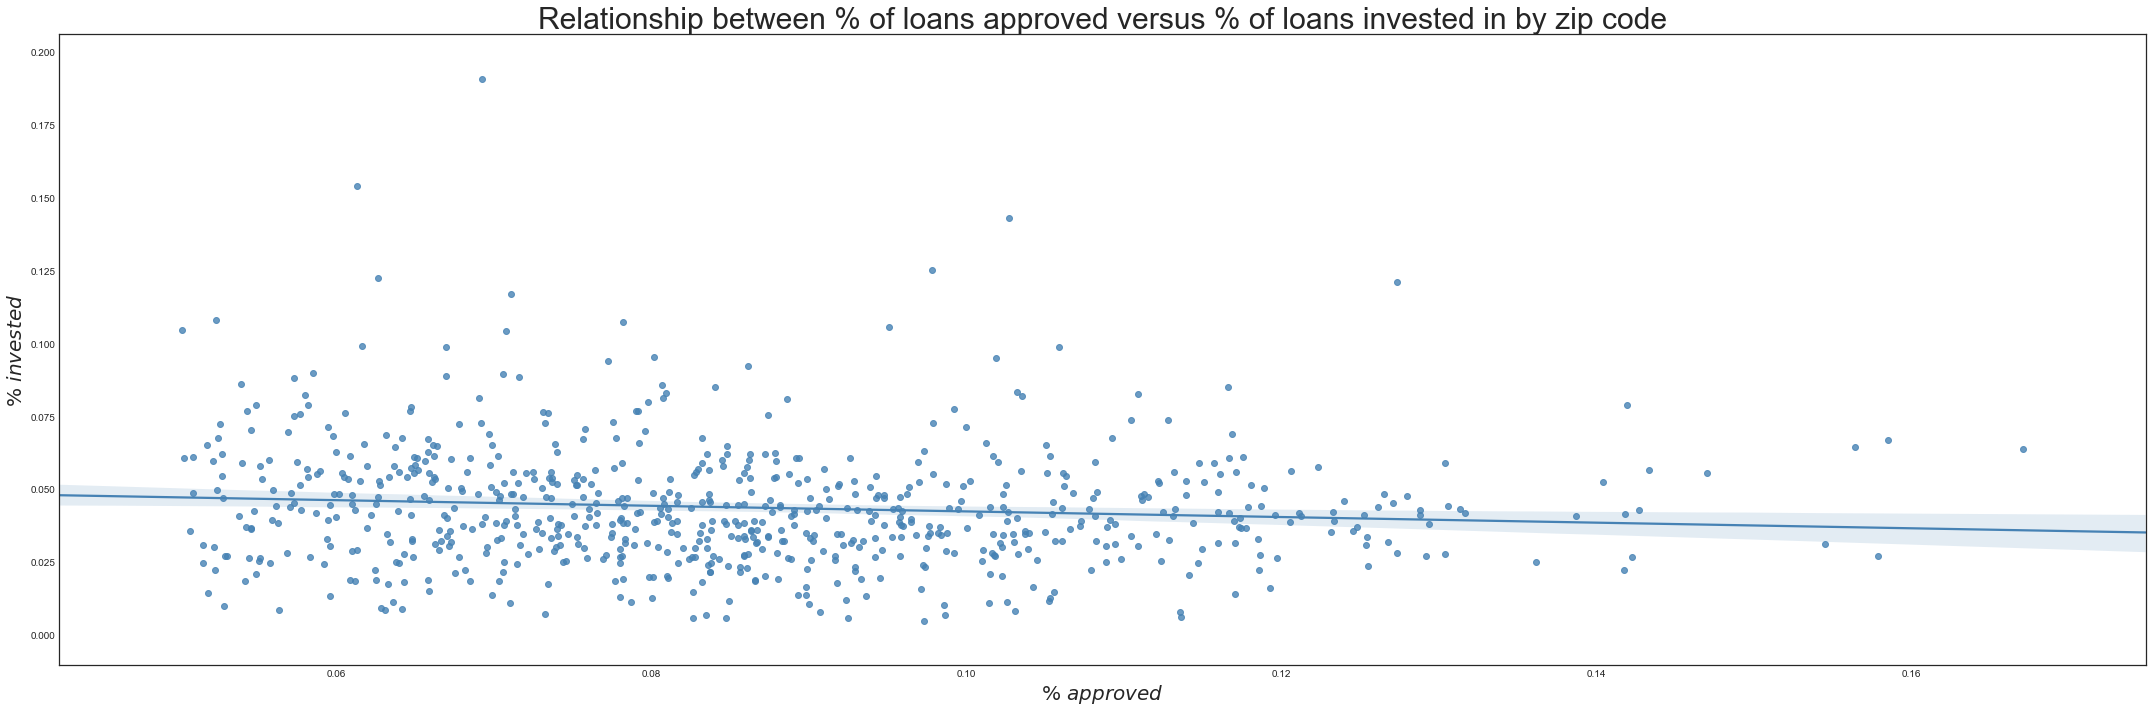

In [175]:
plt.figure(figsize=(30,10))
# sns.regplot(loans_approved_invested14.pct_accepted[loans_approved_invested14.num_loan_apps_considered > 200], 
#             loans_approved_invested14.pct_invested[loans_approved_invested14.num_loan_apps_considered > 200])
sns.regplot(loans_approved_invested14.pct_accepted[loans_approved_invested14.pct_accepted > 0.05], 
            loans_approved_invested14.pct_invested[loans_approved_invested14.pct_accepted > 0.05], color="steelblue")
plt.xlabel(r'$\%\ approved$', fontsize=20)
plt.ylabel(r'$\%\ invested$', fontsize=20)
plt.title('Relationship between % of loans approved versus % of loans invested in by zip code', fontsize=30)
plt.tight_layout()
plt.savefig('pct_loansapproved_loansinvest.png')

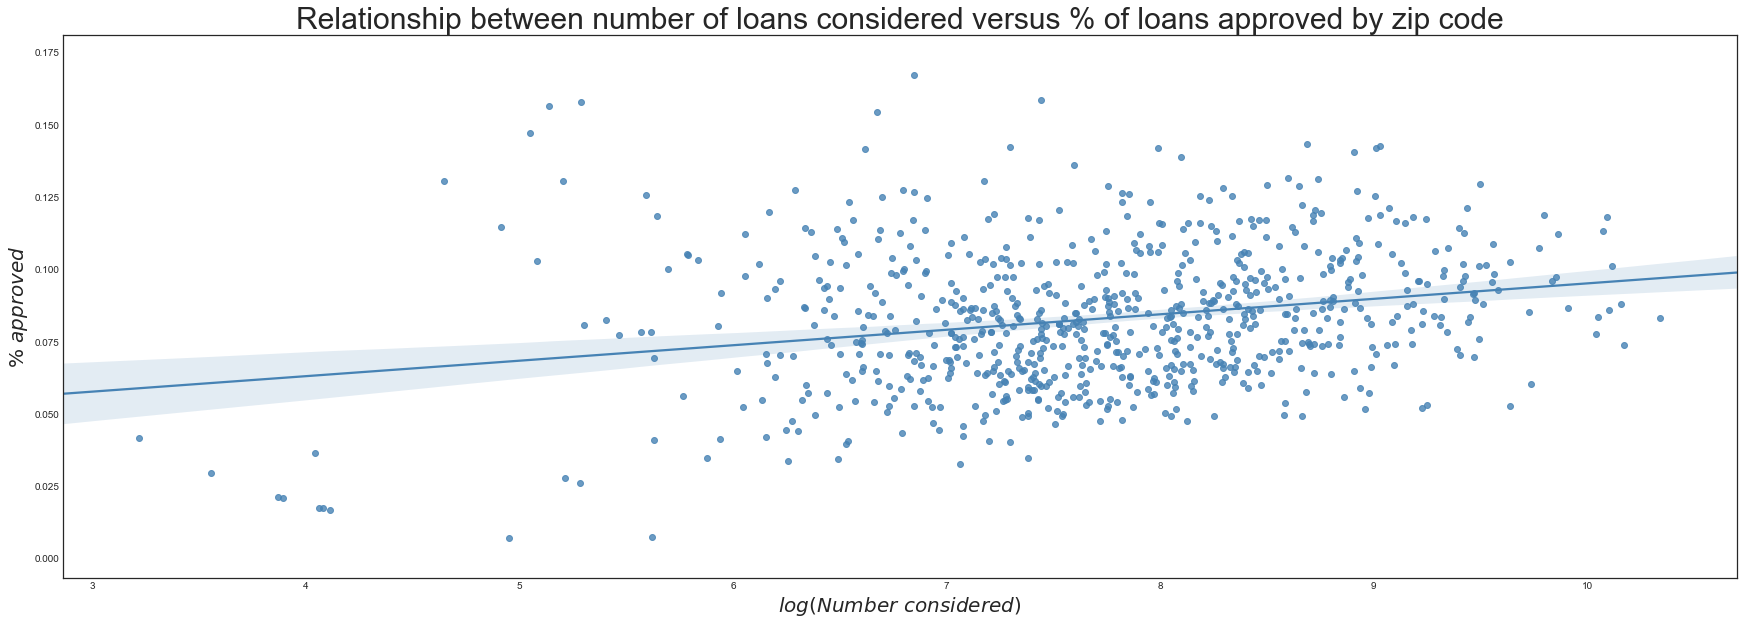

In [176]:
plt.figure(figsize=(30,10))
sns.regplot(np.log(loans_approved_invested14.num_loan_apps_considered), loans_approved_invested14.pct_accepted, 
            color="steelblue")
plt.xlabel(r'$log(Number\ considered)$', fontsize=20)
plt.ylabel(r'$\%\ approved$', fontsize=20)
plt.title('Relationship between number of loans considered versus % of loans approved by zip code', fontsize=30)
plt.show()

Now let's try different kinds of parity.

In [181]:
# Statistical parity
# race, family status, education, unemployment
def statistical_parity_measures(full_data, subset_data, protected, investment):
    # quartiles
    tiles = np.percentile(protected.dropna(), [0,25,50,75,100])
    _0_25 = protected <= tiles[1]
    _25_50 = (protected <= tiles[2]) & (protected > tiles[1])
    _50_75 = (protected <= tiles[3]) & (protected > tiles[2])
    _75_100 = (protected <= tiles[4]) & (protected > tiles[3])
    
    # calculate money invested in from all loans per quartile in initial strategy
    amnt_recommend_invest_before = [np.sum(subset_data.amnt[_0_25]), np.sum(subset_data.amnt[_25_50]),
                                    np.sum(subset_data.amnt[_50_75]), np.sum(subset_data.amnt[_75_100])]
    
    # calculate money invested in each quartile after adjustment
    ranked025 = full_data[_0_25].sort_values('Rank', ascending=False)
    ranked2550 = full_data[_25_50].sort_values('Rank', ascending=False)
    ranked5075 = full_data[_50_75].sort_values('Rank', ascending=False)
    ranked75100 = full_data[_75_100].sort_values('Rank', ascending=False)
    ranked025.loc[_0_25, 'cumsum_amnt'] = ranked025.loc[_0_25,'amnt'].cumsum()
    ranked2550.loc[_25_50, 'cumsum_amnt'] = ranked2550.loc[_25_50,'amnt'].cumsum()
    ranked5075.loc[_50_75, 'cumsum_amnt'] = ranked5075.loc[_50_75,'amnt'].cumsum()
    ranked75100.loc[_75_100, 'cumsum_amnt'] = ranked75100.loc[_75_100,'amnt'].cumsum()

    _0_25_underQuarterInvestment = ranked025.cumsum_amnt <= investment/4
    _25_50_underQuarterInvestment = ranked2550.cumsum_amnt <= investment/4
    _50_75_underQuarterInvestment = ranked5075.cumsum_amnt <= investment/4
    _75_100_underQuarterInvestment = ranked75100.cumsum_amnt <= investment/4                         
    
    amnt_recommend_invest_after = [np.sum(ranked025.amnt[_0_25_underQuarterInvestment]), 
                                   np.sum(ranked2550.amnt[_25_50_underQuarterInvestment]), 
                                   np.sum(ranked5075.amnt[_50_75_underQuarterInvestment]), 
                                   np.sum(ranked75100.amnt[_75_100_underQuarterInvestment])]
    
    # calculate return for the loans selected from each quartile 
    annualized_return_quartile = [np.sum(ranked025.Real_ROI[_0_25_underQuarterInvestment])/np.sum(ranked025.annualized_amnt[_0_25_underQuarterInvestment]),
                                  np.sum(ranked2550.Real_ROI[_25_50_underQuarterInvestment])/np.sum(ranked2550.annualized_amnt[_25_50_underQuarterInvestment]),
                                  np.sum(ranked5075.Real_ROI[_50_75_underQuarterInvestment])/np.sum(ranked5075.annualized_amnt[_50_75_underQuarterInvestment]),
                                  np.sum(ranked75100.Real_ROI[_75_100_underQuarterInvestment])/np.sum(ranked75100.annualized_amnt[_75_100_underQuarterInvestment])]

    # calculate overall return from this stategy
    # weight by number of loans
    num_loans_from_quartile = [np.sum(_0_25_underQuarterInvestment), np.sum(_25_50_underQuarterInvestment), 
                               np.sum(_50_75_underQuarterInvestment), np.sum(_75_100_underQuarterInvestment)]  
    overall_return = np.average(annualized_return_quartile, weights=num_loans_from_quartile)
    
    return amnt_recommend_invest_before, amnt_recommend_invest_after, annualized_return_quartile, overall_return


In [182]:
# Recall baseline performance
print('all 2014',np.sum(all_loans_2014_merged.Real_ROI)/np.sum(all_loans_2014_merged.annualized_amnt))
print('subset 2014',np.sum(loans_bought14_merged.Real_ROI.dropna())/np.sum(loans_bought14_merged.annualized_amnt.dropna()))
prop_loans_invested14 = len(loans_bought14_merged)/len(all_loans_2014_merged)
print('prop of loans we invest in 2014', prop_loans_invested14)

all 2014 0.06527042393002869
subset 2014 0.07510692628929128
prop of loans we invest in 2014 0.04466543591610794


In [188]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
protected_features = ['Bachelors_Degree_pct','nonwhite_pct','Unemployment_Rate_pct','Single_parent_families']
for feature in protected_features:
    
    arib, aria, arq, ovret = statistical_parity_measures(all_loans_2014_merged, loans_bought14_merged, all_loans_2014_merged[feature], 200000000)
    
    print('\n',feature)
    display(pd.DataFrame(np.concatenate([np.array(arib).reshape(-1,1), np.array(aria).reshape(-1,1), 
                                 np.array(arq).reshape(-1,1)], axis=1),
                columns=['Money invested before', 'Money invested after', 'Return by quartile'],
                index=['1st quartile','2nd quartile','3rd quartile','4th quartile']))
    print('Overall return:', ovret)


 Bachelors_Degree_pct


,Money invested before,Money invested after,Return by quartile
1st quartile,15169950.000,49970500.000,0.080
2nd quartile,38457300.000,49971075.000,0.079
3rd quartile,58331225.000,49999900.000,0.081
4th quartile,120500750.000,49986275.000,0.075


Overall return: 0.07901806547060033

 nonwhite_pct


,Money invested before,Money invested after,Return by quartile
1st quartile,54718150.000,49982750.000,0.079
2nd quartile,64374675.000,49985750.000,0.080
3rd quartile,65082750.000,49999550.000,0.078
4th quartile,48283650.000,49986775.000,0.082


Overall return: 0.0795883982044848

 Unemployment_Rate_pct


,Money invested before,Money invested after,Return by quartile
1st quartile,96089500.000,49987350.000,0.079
2nd quartile,70145775.000,49995600.000,0.077
3rd quartile,43131575.000,49969525.000,0.083
4th quartile,23092375.000,49995125.000,0.080


Overall return: 0.07966267480200871

 Single_parent_families


,Money invested before,Money invested after,Return by quartile
1st quartile,99565350.000,49989225.000,0.079
2nd quartile,69932950.000,49986475.000,0.080
3rd quartile,43132500.000,49983200.000,0.080
4th quartile,19828425.000,49993250.000,0.079


Overall return: 0.07944951212631234


In [193]:
res14 = all_loans_2014_merged.sort_values('Rank', ascending=False)
res14.loc[:, 'cumsum_amnt'] = res14.loc[:,'amnt'].cumsum()
ind_to_use = res14.cumsum_amnt <= 200000000
np.sum(res14.Real_ROI[ind_to_use])/np.sum(res14.annualized_amnt[ind_to_use])

0.07976091415314147

Now do the same for 2015.

In [189]:
# Recall baseline performance
print('all 2015',np.sum(all_loans_2015_merged.Real_ROI)/np.sum(all_loans_2015_merged.annualized_amnt))
print('subset 2015',np.sum(loans_bought15_merged.Real_ROI.dropna())/np.sum(loans_bought15_merged.annualized_amnt.dropna()))
prop_loans_invested15 = len(loans_bought15_merged)/len(all_loans_2015_merged)
print('prop of loans we invest in 2014', prop_loans_invested15)

all 2015 -0.012904786449367612
subset 2015 0.0471881958771565
prop of loans we invest in 2014 0.009518878675513546


In [191]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
protected_features = ['Bachelors_Degree_pct','nonwhite_pct','Unemployment_Rate_pct','Single_parent_families']
for feature in protected_features:
    
    arib, aria, arq, ovret = statistical_parity_measures(all_loans_2015_merged, loans_bought15_merged, all_loans_2015_merged[feature], 200000000)
    
    print('\n',feature)
    display(pd.DataFrame(np.concatenate([np.array(arib).reshape(-1,1), np.array(aria).reshape(-1,1), 
                                 np.array(arq).reshape(-1,1)], axis=1),
                columns=['Money invested before', 'Money invested after', 'Return by quartile'],
                index=['1st quartile','2nd quartile','3rd quartile','4th quartile']))
    print('Overall return:', ovret)


 Bachelors_Degree_pct


,Money invested before,Money invested after,Return by quartile
1st quartile,1700200.000,49987650.000,0.059
2nd quartile,5287850.000,49999700.000,0.059
3rd quartile,9556325.000,49972700.000,0.061
4th quartile,29975125.000,49999650.000,0.059


Overall return: 0.05953933622885001

 nonwhite_pct


,Money invested before,Money invested after,Return by quartile
1st quartile,10208050.000,49985700.000,0.057
2nd quartile,12090300.000,49973325.000,0.062
3rd quartile,14552475.000,49995725.000,0.057
4th quartile,9668675.000,49995575.000,0.060


Overall return: 0.05899651163081266

 Unemployment_Rate_pct


,Money invested before,Money invested after,Return by quartile
1st quartile,21347125.000,49995850.000,0.057
2nd quartile,15317375.000,49983425.000,0.062
3rd quartile,6569600.000,49993400.000,0.055
4th quartile,3285400.000,49977450.000,0.061


Overall return: 0.05889685300592554

 Single_parent_families


,Money invested before,Money invested after,Return by quartile
1st quartile,22153650.000,49993325.000,0.057
2nd quartile,14131050.000,49983075.000,0.057
3rd quartile,7773900.000,49990675.000,0.062
4th quartile,2460900.000,49996275.000,0.058


Overall return: 0.05840184613182443


In [192]:
res15 = all_loans_2015_merged.sort_values('Rank', ascending=False)
res15.loc[:, 'cumsum_amnt'] = res15.loc[:,'amnt'].cumsum()
ind_to_use = res15.cumsum_amnt <= 200000000
np.sum(res15.Real_ROI[ind_to_use])/np.sum(res15.annualized_amnt[ind_to_use])

0.058604646404614234

# Fairness models

Includes themis-ml, AIF360 and also post-checks from LIME and QII. Will focus more on AIF360 here.

In [14]:
# Disparate impact remover
# running through their example code 1st
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

In [18]:
from aif360.datasets import AdultDataset

In [19]:
protected = 'sex'
ad = AdultDataset(protected_attribute_names=[protected],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [23]:
scaler = MinMaxScaler(copy=False)
train, test = ad.split([32561])
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index(protected)

In [32]:
warnings.filterwarnings('ignore', category=UserWarning)
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(solver='lbfgs', class_weight='balanced')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

  0%|          | 0/11 [00:00<?, ?it/s]/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  9%|▉         | 1/11 [00:04<00:43,  4.39s/it]/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
 18%|█▊        | 2/11 [00:08<00:39,  4.39s/it]/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
 27%|██▋       | 3/11 [00:13<00:34,  4.34s/it]/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' 

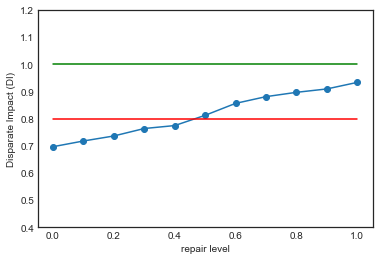

In [35]:
plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

In [38]:
# data is np arrays of shape (rows, cols)
# unsure the type of train

(32561, 5)

In [42]:
ad

               instance weights      features               \
                                                             
                                education-num capital-gain   
instance names                                               
0                           1.0          13.0       2174.0   
1                           1.0          13.0          0.0   
2                           1.0           9.0          0.0   
3                           1.0           7.0          0.0   
4                           1.0          13.0          0.0   
5                           1.0          14.0          0.0   
6                           1.0           5.0          0.0   
7                           1.0           9.0          0.0   
8                           1.0          14.0      14084.0   
9                           1.0          13.0       5178.0   
10                          1.0          10.0          0.0   
11                          1.0          13.0          0.0   
12      